In [407]:
# import all nessessary modules
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fmin_cg
from scipy.optimize import minimize
import pandas as pd
eps = 0.001

# setup the plotting parameters
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams["figure.dpi"] = 100
img_dir = "./images/"

# Class Function provides interface for 
# function and its gradient
class Function:
    def __init__(self, func, grad=None):
        self.func = func
        if grad:
            self.grad = grad
    
    def call(self, x, a, b):
        return self.func(x, a, b)
    
    def grad(self, x, a, b):
        if hasattr(self, "grad"):
            return self.grad(x, a, b)
        else:
            raise AttributeError("No gradient provided")
        
# Function for calculation MSE
def mse_loss(params, y, func):
    x = np.linspace(eps, 1, 100)
    a, b = params
    mse = np.mean( (func.call(x, a, b) - y)**2 )
    
    return mse

# Function for calculation gradient of MSE
def mse_grad(params, y, func):
    x = np.linspace(eps, 1, 100)
    a, b = params
    mse_grad = func.call(x, a, b) - y
    mse_grad = np.multiply(mse_grad,  func.grad(x, a, b))
    mse_grad = np.mean(mse_grad, axis=1)
    
    return mse_grad 

# Function for gradient descent algorithm
def gradient_descent(mse_func, y, func, init_guess, gamma=0.1, max_iter=1000 ):
    n_iter = 0
    pred = init_guess
    while n_iter < max_iter:
        step = gamma*mse_func.grad(pred, y, func)*pred
        pred -= step
        n_iter += 1

        if max(abs(step)) < eps:
            break
        
    return pred, n_iter
    

# Defince objects for linear, rational and mse functions
linear = Function( lambda x, a, b: a*x+b, lambda x, a, b: [x, [1]*len(x)] )
rational = Function( lambda x, a, b: a/(1+b*x), lambda x, a, b: [1/(1+b*x), -a*x*(1+b*x)**(-2)] )

mse_func = Function(mse_loss, mse_grad)

In [408]:
# Function to generate noised data
def generate_data(k=100):
    alpha, beta = np.random.uniform(size=(1, 2))[0]
    data = [alpha*x+beta + np.random.normal(0, 0.1) for x in np.linspace(eps, 1, k)]
    
    return alpha, beta, data

alpha, beta, y = generate_data()
x = np.linspace(eps, 1, 100)

In [409]:
# Optimize linear function using gradient descent
init_guess = np.random.uniform(size=2)
lin_grad_res = gradient_descent(mse_func, y, linear, init_guess, gamma=1)

In [410]:
# Optimize rational function using gradient descent
init_guess = [np.random.uniform(0.5, 1), np.random.uniform(-0.7, -0.4)]
rat_grad_res = gradient_descent(mse_func, y, rational, init_guess, gamma=0.02)

In [411]:
# Optimize linear and rational function using Levenberg-Marquardt method
LM_lin_res = curve_fit(linear.call, x, y, method="lm")
LM_rat_res = curve_fit(rational.call, x, y, method="lm")

In [412]:
# Optimize linear and rational function using Conjugate Gradient Descent
init_guess = np.random.uniform(-1, 1, size=2)
CG_lin_res = fmin_cg(mse_func.call, init_guess, mse_func.grad, args=(y, linear))
CG_rat_res = fmin_cg(mse_func.call, init_guess, mse_func.grad, args=(y, rational))

Optimization terminated successfully.
         Current function value: 0.007929
         Iterations: 6
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 0.012538
         Iterations: 17
         Function evaluations: 60
         Gradient evaluations: 60


In [413]:
# Optimize linear and rational function using Newton method
init_guess = np.random.uniform(-1, 1, size=2)
NT_lin_res = minimize(mse_func.call, init_guess, args=(y, linear), tol=0.001, method='Newton-CG',jac=mse_func.grad, options={'disp': True})
NT_rat_res = minimize(mse_func.call, init_guess, args=(y, rational), tol=0.001, method='Newton-CG',jac=mse_func.grad, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.007929
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 14
         Hessian evaluations: 0
Optimization terminated successfully.
         Current function value: 0.012538
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 47
         Hessian evaluations: 0


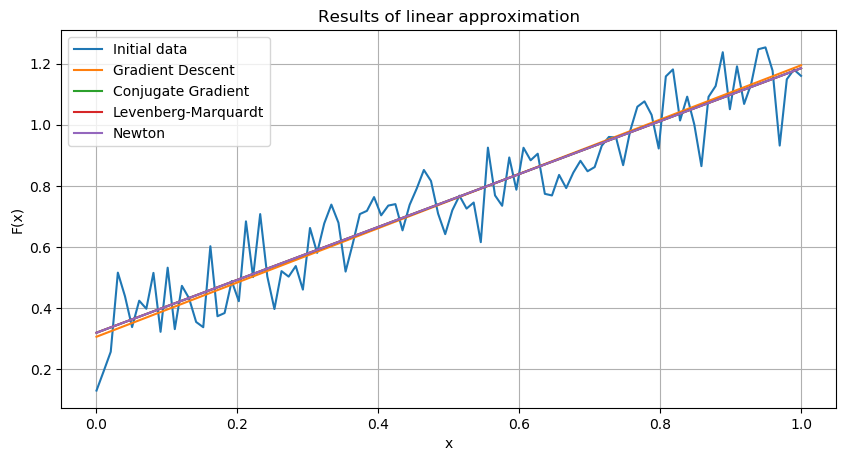

In [415]:
# Plot the results for linear approximation
fig, ax = plt.subplots()
plt.grid()


ax.set_xlabel("x")
ax.set_ylabel("F(x)")
ax.set_title(f"Results of linear approximation")

plt.plot(x, y, label="Initial data")

plt.plot(x, linear.call(x, *lin_grad_res[0]), label="Gradient Descent" )
plt.plot(x, linear.call(x, *CG_lin_res), label="Conjugate Gradient" )
plt.plot(x, linear.call(x, *LM_lin_res[0]), label="Levenberg-Marquardt" )
plt.plot(x, linear.call(x, *NT_lin_res.x), label="Newton" )

_ = plt.legend(loc="upper left")

plt.savefig(img_dir + "lin_results.png")

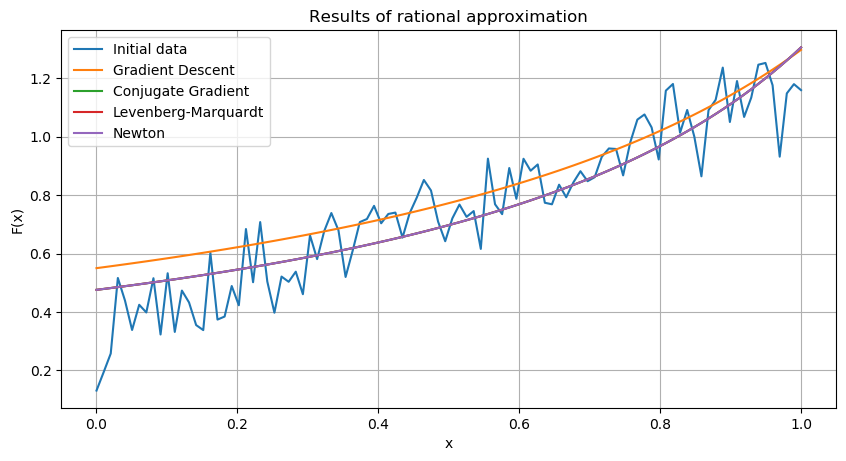

In [416]:
# Plot the results for rational approximation
fig, ax = plt.subplots()
plt.grid()


ax.set_xlabel("x")
ax.set_ylabel("F(x)")
ax.set_title(f"Results of rational approximation")

plt.plot(x, y, label="Initial data")

plt.plot(x, rational.call(x, *rat_grad_res[0]), label="Gradient Descent" )
plt.plot(x, rational.call(x, *CG_rat_res), label="Conjugate Gradient" )
plt.plot(x, rational.call(x, *LM_rat_res[0]), label="Levenberg-Marquardt" )
plt.plot(x, rational.call(x, *NT_rat_res.x), label="Newton" )

_ = plt.legend(loc="upper left")

plt.savefig(img_dir + "rat_results.png")